# Identify Contrails with Keras

In [1]:
# reinstall tensorflow-io
# to avoid the UserWarning: unable to load libtensorflow_io_plugins.so

#!pip install tensorflow-io

---

In [2]:
import os

In [3]:
# ==============================

LOAD_CHECKPOINT = False  # <DEVEL>
TRAIN = True  # <DEVEL>

if os.path.exists('/kaggle'):
    PLATFORM = 'kaggle'
else:
    PLATFORM = 'gcp'

# ==============================

print(f'PLATFORM = {PLATFORM}')
print()
print(f'LOAD_CHECKPOINT = {LOAD_CHECKPOINT}')
print(f'TRAIN = {TRAIN}')

PLATFORM = gcp

LOAD_CHECKPOINT = False
TRAIN = True


In [4]:
if PLATFORM == 'kaggle':

    WORK_DIR = '/kaggle/working'  # preserved if notebook is saved
    TEMP_DIR = '/kaggle/temp'  # just during current session

    DATA_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    
    WEIGHTS_DIR = WORK_DIR
    
    resnet50_imagenet_weights =\
        '/kaggle/input/d/alexisbcook/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

    # You can write up to 20GB to the current directory (/kaggle/working/)
    # that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/,
    # but they won't be saved outside of the current session

elif PLATFORM == 'gcp':

    WORK_DIR = '/home/jupyter/kaggle/working'  # preserved if notebook is saved
    TEMP_DIR = '/home/jupyter/kaggle/temp'  # just during current session

    DATA_DIR = '/home/jupyter/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    
    WEIGHTS_DIR = '/home/jupyter/identify-contrails-models'
    
    resnet50_imagenet_weights = 'imagenet'
    
    %cd $WORK_DIR
    
else:
    raise NotImplementedError(f'unknown platform "{PLATFORM}"')

print('PWD =', os.getcwd())

/home/jupyter/kaggle/working
PWD = /home/jupyter/kaggle/working


In [5]:
UPDATE_DATA = False

if UPDATE_DATA:
    %cp -v /kaggle/input/identify-contrails/contrails_2023*.h5 .
    %ll

In [6]:
if LOAD_CHECKPOINT:
    prev_checkpoint_path = os.path.join(WEIGHTS_DIR, 'contrails_2023-07-22_16-22-01.h5')  # <DEVEL>
    print(f'prev_checkpoint_path = {prev_checkpoint_path}')
    if not os.path.exists(prev_checkpoint_path):
        raise IOError(f'file does not exist {prev_checkpoint_path}')

In [7]:
!touch submission.csv
%ll -h

total 2.4G
-rw-r--r-- 1 jupyter 137M Jul 21 10:05 contrails_2023-07-21_10-35-27.h5
-rw-r--r-- 1 jupyter 137M Jul 22 15:25 contrails_2023-07-22_16-22-01.h5
-rw-r--r-- 1 jupyter 137M Jul 23 16:24 contrails_2023-07-23_18-01-36.h5
-rw-r--r-- 1 jupyter 137M Jul 23 16:37 contrails_2023-07-23_18-31-05.h5
-rw-r--r-- 1 jupyter 137M Jul 23 16:52 contrails_2023-07-23_18-46-16.h5
-rw-r--r-- 1 jupyter 137M Jul 23 17:55 contrails_2023-07-23_19-00-47.h5
-rw-r--r-- 1 jupyter 137M Jul 23 18:36 contrails_2023-07-23_20-31-58.h5
-rw-r--r-- 1 jupyter 137M Jul 23 18:48 contrails_2023-07-23_20-39-57.h5
-rw-r--r-- 1 jupyter 137M Jul 23 18:52 contrails_2023-07-23_20-50-23.h5
-rw-r--r-- 1 jupyter 137M Jul 23 18:58 contrails_2023-07-23_20-56-11.h5
-rw-r--r-- 1 jupyter 137M Jul 23 19:07 contrails_2023-07-23_20-59-30.h5
-rw-r--r-- 1 jupyter 137M Jul 23 19:46 contrails_2023-07-23_21-21-16.h5
-rw-r--r-- 1 jupyter 137M Jul 23 20:26 contrails_2023-07-23_22-06-07.h5
-rw-r--r-- 1 jupyter 137M Jul 23 21:11 contrails_2023

---

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import datetime
import itertools
import math
import multiprocessing
import pathlib
import random
import shutil

from pprint import pprint
from pytz import timezone
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy

In [9]:
PRINT_TIME_FORMAT = "%Y-%m-%d %H:%M:%S %Z%z"
FILE_TIME_FORMAT = "%Y-%m-%d_%H-%M-%S"

start_time = datetime.datetime.now(timezone('CET'))

file_time_str = start_time.strftime(FILE_TIME_FORMAT)

print('Started', start_time.strftime(PRINT_TIME_FORMAT))

Started 2023-07-24 18:25:59 CEST+0200


In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as backend

AUTOTUNE = tf.data.AUTOTUNE

2023-07-24 16:26:00.009728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 16:26:03.336981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-07-24 16:26:03.337929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or di

In [11]:
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.11.0


In [12]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('cpu_count: ', multiprocessing.cpu_count())

Num CPUs Available:  1
Num GPUs Available:  1
cpu_count:  4


2023-07-24 16:26:06.524191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 16:26:06.660626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 16:26:06.660920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [13]:
#---------------------------------------------------------------------------79

# Dataset utils

In [14]:
class Paths:
    train = os.path.join(DATA_DIR, 'train')
    valid = os.path.join(DATA_DIR, 'validation')
    test = os.path.join(DATA_DIR, 'test')

In [15]:
train_ids = sorted(os.listdir(Paths.train))
valid_ids = sorted(os.listdir(Paths.valid))
test_ids = sorted(os.listdir(Paths.test))
print('n_samples (train, validation, test) =', len(train_ids), len(valid_ids), len(test_ids))

n_samples (train, validation, test) = 20529 1856 2


In [16]:
class ABI:
    bands = {name: idx for idx, name in enumerate([
        '08', '09', '10', '11', '12', '13', '14', '15', '16'])}
    colors = {name: idx for idx, name in enumerate([
        'red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black'])}

In [17]:
N_TIMES_BEFORE = 4
N_TIMES_AFTER = 3

In [18]:
def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def get_ash_colors(sample_id, split_dir):
    """
    Based on bands: 11, 14, 15
    
    Args:
        sample_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    band15 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_15.npy")
    band14 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_14.npy")
    band11 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_11.npy")

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    ash_colors = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    
    return ash_colors

In [19]:
def get_individual_mask(sample_id, split_dir):
    masks_path = DATA_DIR + f"/{split_dir}/{sample_id}/human_individual_masks.npy"
    pixel_mask = np.load(masks_path)
    return pixel_mask

def get_pixel_mask(sample_id, split_dir):
    masks_path = DATA_DIR + f"/{split_dir}/{sample_id}/human_pixel_masks.npy"
    pixel_mask = np.load(masks_path)
    return pixel_mask

### Check some values

In [20]:
sample_id = 7829917977180135058  # train_ids[3]

print(f'Check `ash_colors` on one of the samples: {sample_id}')

ash_colors = get_ash_colors(sample_id, 'train')[..., N_TIMES_BEFORE]

print(ash_colors.shape)
for color in range(3):
    array = ash_colors[..., color]
    print(array.min(), array.max())

Check `ash_colors` on one of the samples: 7829917977180135058
(256, 256, 3)
0.0 0.50921124
0.097476535 0.86938816
0.031865694 0.81146187


In [21]:
pixel_mask = get_pixel_mask(sample_id, 'train')

print(pixel_mask.shape)
print(pixel_mask.min(), pixel_mask.max())

(256, 256, 1)
0 1


# Model

In [22]:
SEED = 42

In [23]:
class Config:  # <CONFIG>
    
    seed = SEED

    img_size = (256, 256)
    
    model = 'deeplabv3plus'  # unet | deeplabv3plus
    preprocess = None
    backbone_trainable = True
    dropout = True
    
    num_epochs = 10  # <DEVEL> else 10
    num_classes = 1
    batch_size = 16  # <DEVEL> else 16 or 32
    
    threshold = 'auto'

In [24]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(Config.seed)

# See also:
# tf.config.experimental.enable_op_determinism()

In [25]:
# Mixed Precision
# https://www.tensorflow.org/guide/mixed_precision#supported_hardware

if PLATFORM == 'kaggle':
    MIXED_PRECISION = True
elif PLATFORM == 'gcp':
    # No mixed precision on QCP:
    # "Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0.
    # Your GPU: Tesla P100-PCIE-16GB, compute capability 6.0"
    MIXED_PRECISION = False
else:
    raise NotImplementedError(f'unknown platform "{PLATFORM}"')

if MIXED_PRECISION:
    print('setting mixed_precision')

    NP_FLOAT = 'float16'
    TF_FLOAT = tf.float16
    
    keras.mixed_precision.set_global_policy('mixed_float16')
    final_dtype = 'float32'
    
else:
    print('no mixed_precision')

    NP_FLOAT = 'float32'
    TF_FLOAT = tf.float32

    final_dtype = None

no mixed_precision


In [26]:
class UNet:
    '''U-Net model.
    
    Inspired by and adapted from:
    - https://keras.io/examples/vision/oxford_pets_image_segmentation
    - https://www.kaggle.com/code/shashwatraman/simple-unet-baseline-train-lb-0-580
    - https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/home/week/3
    '''
    
    def __init__(self, preprocess=None, weights=None):
        self.preprocess = preprocess
        self.weights = weights
        
    def conv2d_block(self, input_tensor, n_filters, kernel_size=3):
        x = input_tensor
        for i in range(2):
            x = tf.keras.layers.SeparableConv2D(
                filters = n_filters, kernel_size=(kernel_size, kernel_size), padding='same')(x)
            #? kernel_initializer = 'he_normal'
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
        return x

    def encoder_block(self, inputs, n_filters, pool_size, dropout):
        f = self.conv2d_block(inputs, n_filters=n_filters)
        p = tf.keras.layers.MaxPooling2D(pool_size)(f)
        p = tf.keras.layers.Dropout(dropout)(p)
        return f, p

    def encoder(self, inputs, dropout=0.1):
        f1, p1 = self.encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=dropout)
        f2, p2 = self.encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=dropout)
        f3, p3 = self.encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=dropout)
        f4, p4 = self.encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=dropout)
        return p4, (f1, f2, f3, f4)

    def bottleneck(self, inputs):
        bottle_neck = self.conv2d_block(inputs, n_filters=1024)
        return bottle_neck

    def decoder_block(self, inputs, conv_output, n_filters, kernel_size, strides, dropout):
        u = tf.keras.layers.Conv2DTranspose(
            n_filters, kernel_size, strides=strides, padding = 'same')(inputs)
        u = tf.keras.layers.BatchNormalization()(u)
        c = tf.keras.layers.concatenate([u, conv_output])
        c = tf.keras.layers.Dropout(dropout)(c)
        c = self.conv2d_block(c, n_filters, kernel_size=3)
        return c

    def decoder(self, inputs, convs, num_classes, dropout=0.1):
        f1, f2, f3, f4 = convs
        c6 = self.decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=dropout)
        c7 = self.decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=dropout)
        c8 = self.decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=dropout)
        c9 = self.decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=dropout)
        if num_classes == 1:
            activation = "sigmoid"
        else:
            activation = "softmax"
        outputs = layers.Conv2D(
            num_classes, kernel_size=3, activation=activation, padding="same", dtype=final_dtype)(c9)
        return outputs

    def model(self, image_size, num_classes):
        inputs = tf.keras.layers.Input(shape=(image_size,image_size,3))
        encoder_output, convs = self.encoder(inputs)
        #model = tf.keras.Model(inputs=inputs, outputs=encoder_output)  # debug
        bottle_neck = self.bottleneck(encoder_output)
        outputs = self.decoder(bottle_neck, convs, num_classes)
        model = tf.keras.Model(name=self.__class__.__name__, inputs=inputs, outputs=outputs)
        return model

In [27]:
class DeepLabV3Plus:
    '''DeepLabV3+ model.
    
    Adapted from:
    - https://keras.io/examples/vision/deeplabv3_plus/#inference-using-colormap-overlay
    
    Dropout from:
    - https://github.com/smspillaz/seg-reg
    '''
    
    def __init__(self, preprocess='resnet50', weights='imagenet', resnet50_trainable=True,
                 dropout=False):
        self.preprocess = preprocess
        self.weights = weights
        self.resnet50_trainable = resnet50_trainable
        self.dropout = dropout
    
    def convolution_block(
        self,
        block_input,
        num_filters=256,
        kernel_size=3,
        dilation_rate=1,
        padding="same",
        use_bias=False,
    ):
        x = layers.Conv2D(
            num_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding="same",
            use_bias=use_bias,
            kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
        x = layers.BatchNormalization()(x)
        return tf.nn.relu(x)

    def DilatedSpatialPyramidPooling(self, dspp_input):
        dims = dspp_input.shape
        x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
        
        x = self.convolution_block(x, kernel_size=1, use_bias=True)
        out_pool = layers.UpSampling2D(
            size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
        )(x)

        out_1 = self.convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
        out_6 = self.convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
        out_12 = self.convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
        out_18 = self.convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

        x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
        output = self.convolution_block(x, kernel_size=1)

        if self.dropout:
            output = tf.keras.layers.Dropout(0.1)(output)
        
        return output
    
    def model(self, image_size, num_classes):
        
        model_input = keras.Input(shape=(image_size, image_size, 3))
        
        resnet50 = keras.applications.ResNet50(
            weights=self.weights, include_top=False, input_tensor=model_input,
        )
        resnet50.trainable = self.resnet50_trainable
        print('resnet50.trainable =', resnet50.trainable)
        
        x = resnet50.get_layer("conv4_block6_2_relu").output
        x = self.DilatedSpatialPyramidPooling(x)

        input_a = layers.UpSampling2D(
            size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
            interpolation="bilinear",
        )(x)
        input_b = resnet50.get_layer("conv2_block3_2_relu").output
        input_b = self.convolution_block(input_b, num_filters=48, kernel_size=1)

        x = layers.Concatenate(axis=-1)([input_a, input_b])
        x = self.convolution_block(x)
        if self.dropout:
            x = tf.keras.layers.Dropout(0.5)(x)
        x = self.convolution_block(x)
        if self.dropout:
            x = tf.keras.layers.Dropout(0.1)(x)
        x = layers.UpSampling2D(
            size=(image_size // x.shape[1], image_size // x.shape[2]),
            interpolation="bilinear",
        )(x)
        
        if num_classes == 1:
            activation = "sigmoid"
        else:
            activation = "softmax"
        model_output = layers.Conv2D(
            num_classes, kernel_size=(1, 1), activation=activation, padding="same", dtype=final_dtype)(x)
        
        return keras.Model(name=self.__class__.__name__, inputs=model_input, outputs=model_output)    

In [28]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
if Config.model == 'unet':
    builder = UNet()

elif Config.model == 'deeplabv3plus':
    builder = DeepLabV3Plus(
        preprocess=Config.preprocess,
        weights=resnet50_imagenet_weights,
        resnet50_trainable=Config.backbone_trainable,
        dropout=Config.dropout
    )
    
else:
    raise NotImplementedError(f'model "{Config.model}"')
    
model = builder.model(image_size=Config.img_size[0], num_classes=Config.num_classes)
model.summary()

2023-07-24 16:26:08.051315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 16:26:08.052029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 16:26:08.052353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 16:26:08.052531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

resnet50.trainable = True
Model: "DeepLabV3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                            

# Configure datasets (keras)

In [29]:
N_TRAIN = None  # 512 <DEVEL> else None
N_VALID = None  # 128 <DEVEL> else None (1856)
N_PARTIAL = 128  # 128

In [30]:
print('preprocess =', builder.preprocess)

preprocess = None


In [31]:
class AshColorSingleFrames(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, sample_ids, split_dir, preprocess=None, n_samples=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.split_dir = split_dir
        self.sample_ids = sample_ids[:n_samples]
        self.preprocess = preprocess

    def __len__(self):
        return math.ceil(len(self.sample_ids) / self.batch_size)
    
    def get_sample_ids(self, idx):
        '''Get sample ids of batch idx.'''
        i = idx * self.batch_size
        return self.sample_ids[i : i + self.batch_size]
    
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        
        batch_sample_ids = self.get_sample_ids(idx)
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=NP_FLOAT)
        for j, sample_id in enumerate(batch_sample_ids):
            
            img = get_ash_colors(sample_id, self.split_dir)[..., N_TIMES_BEFORE]
            
            if self.preprocess == 'resnet50':
                img = keras.applications.resnet50.preprocess_input(img)
            elif self.preprocess is not None:
                raise NotImplementedError(f'preprocess "{preprocess}"')
            
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        if self.split_dir != 'test':
            for j, sample_id in enumerate(batch_sample_ids):
                img = get_pixel_mask(sample_id, self.split_dir)
                y[j] = img
        
        return x, y

In [32]:
train_set = AshColorSingleFrames(
    Config.batch_size, Config.img_size, train_ids, 'train',
    preprocess=builder.preprocess, n_samples=N_TRAIN)
print('number of batches:', len(train_set), 'train')

valid_set = AshColorSingleFrames(
    Config.batch_size, Config.img_size, valid_ids, 'validation',
    preprocess=builder.preprocess, n_samples=N_VALID)
print('number of batches:', len(valid_set), 'valid')

partial_set = AshColorSingleFrames(
    Config.batch_size, Config.img_size, valid_ids, 'validation',
    preprocess=builder.preprocess, n_samples=N_PARTIAL)
print('number of batches:', len(partial_set), 'partial')

test_set = AshColorSingleFrames(
    Config.batch_size, Config.img_size, test_ids, 'test',
    preprocess=builder.preprocess)
print('number of batches:', len(test_set), 'test')

number of batches: 1284 train
number of batches: 116 valid
number of batches: 8 partial
number of batches: 1 test


In [33]:
print('Check dimensions (x, y) of first batch:')

train_set[0][0].shape, train_set[0][1].shape

Check dimensions (x, y) of first batch:


((16, 256, 256, 3), (16, 256, 256, 1))

# Generate TFRecords

In [34]:
class TFDataSetCreator:
    '''Write TFRecords files and generate a TFRecordDataset from a keras.Sequence.
    
    Inspired by:
    - https://www.tensorflow.org/tutorials/load_data/tfrecord
    - https://keras.io/examples/keras_recipes/creating_tfrecords
    - https://keras.io/examples/keras_recipes/tfrecord
    - https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord
    
    References:
    - https://www.tensorflow.org/guide/data - Build TensorFlow input pipelines
    - https://www.tensorflow.org/guide/data_performance - Better performance with the tf.data API
    '''
    
    def __init__(self, keras_sequence):
        self.keras_sequence = keras_sequence
        self.split_dir = keras_sequence.split_dir
        self.batch_size = keras_sequence.batch_size
        
        self.keep_existing = True
        self.records_dir = os.path.join(TEMP_DIR, f'records-{self.batch_size}-{self.split_dir}')
        self.record_paths = []
        
        self.progress_bar = True  # <DEVEL>
    
    def write_tfrec(self, batch_idx):
        #pid = multiprocessing.current_process().pid
        
        record_path = os.path.join(self.records_dir, f'batch_{batch_idx:04d}.tfrec')
        
        if self.keep_existing and os.path.exists(record_path):
            return record_path
        
        if self.progress_bar:
            if batch_idx % 100 == 0:
                print('o', end='')
            else:
                print('.', end='')

        x_b, y_b = self.keras_sequence[batch_idx]
        with tf.io.TFRecordWriter(record_path) as writer:
            for x, y in zip(x_b, y_b):
                feature = {
                    "x": tf.train.Feature(
                        bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(x).numpy()])),
                    "y": tf.train.Feature(
                        bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(y).numpy()])),
                }
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())
        
        return record_path
    
    def generate_tfrec(self, keep_existing=True):
        
        self.keep_existing = keep_existing
        
        records_dir = self.records_dir
        os.makedirs(records_dir, exist_ok=True)
        
        n_records = len(self.keras_sequence)
        n_procs = multiprocessing.cpu_count() * 2
        print(f'generating {n_records} records with {n_procs} processes in: {records_dir}')
        %ll -hd $records_dir

        pool = multiprocessing.Pool(processes=n_procs)
        batch_indexes = range(n_records)
        record_paths = sorted(pool.map(self.write_tfrec, batch_indexes))
        if self.progress_bar:
            print()
        
        !du -sh $records_dir
        print()
        
        self.record_paths = record_paths
        return self
    
    @staticmethod
    def parse_tfrecord_sample(element):
        parse_dic = {
            'x': tf.io.FixedLenFeature([], tf.string),  # Note that it is tf.string, not tf.float32
            'y': tf.io.FixedLenFeature([], tf.string),  # Note that it is tf.string, not tf.float32
        }
        feature = tf.io.parse_single_example(element, parse_dic)
        feature['x'] = tf.io.parse_tensor(feature['x'], out_type=TF_FLOAT)
        feature['y'] = tf.io.parse_tensor(feature['y'], out_type=tf.uint8)
        return feature

    @staticmethod
    def prepare_sample(features):
        return features['x'], features['y']

    def dataset(self):
        dataset = (
            tf.data.TFRecordDataset(self.record_paths, num_parallel_reads=AUTOTUNE)
            .map(self.parse_tfrecord_sample, num_parallel_calls=AUTOTUNE)
            .map(self.prepare_sample, num_parallel_calls=AUTOTUNE)
            .shuffle(self.batch_size * 10)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        return dataset

In [35]:
KEEP_EXISTING = True  # <DEVEL>

timeit_start = datetime.datetime.now()

tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/CPU:0'):

    tf_train_set = (
        TFDataSetCreator(train_set)
        .generate_tfrec(KEEP_EXISTING)
        .dataset()
    )

    tf_valid_set = (
        TFDataSetCreator(valid_set)
        .generate_tfrec(KEEP_EXISTING)
        .dataset()
    )

    tf_test_set = (
        TFDataSetCreator(test_set)
        .generate_tfrec(KEEP_EXISTING)
        .dataset()
    )

tf.debugging.set_log_device_placement(False)

timeit_end = datetime.datetime.now()
print('datasets generated in:', timeit_end - timeit_start)

generating 1284 records with 8 processes in: /home/jupyter/kaggle/temp/records-16-train
drwxr-xr-x 2 jupyter 40K Jul 23 19:39 /home/jupyter/kaggle/temp/records-16-train/

17G	/home/jupyter/kaggle/temp/records-16-train

generating 116 records with 8 processes in: /home/jupyter/kaggle/temp/records-16-validation
drwxr-xr-x 2 jupyter 4.0K Jul 23 19:41 /home/jupyter/kaggle/temp/records-16-validation/

1.5G	/home/jupyter/kaggle/temp/records-16-validation

generating 1 records with 8 processes in: /home/jupyter/kaggle/temp/records-16-test
drwxr-xr-x 2 jupyter 4.0K Jul 23 18:35 /home/jupyter/kaggle/temp/records-16-test/

14M	/home/jupyter/kaggle/temp/records-16-test

datasets generated in: 0:00:01.970552


# Training

In [36]:
def dice_coef(y_true, y_pred, smooth=0.001, threshold=None):
    '''Dice coefficient.
    
    Adapted from:
    - https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
    - https://www.kaggle.com/code/shashwatraman/simple-unet-baseline-train-lb-0-580
    '''
    
    y_true_f = backend.flatten(tf.cast(y_true, TF_FLOAT))
    y_pred_f = backend.flatten(tf.cast(y_pred, TF_FLOAT))
    # ValueError: No gradients provided for any variable
    if threshold is not None:
        y_pred_f = backend.flatten(
            tf.cast(tf.math.greater(tf.cast(y_pred, TF_FLOAT), threshold), TF_FLOAT))
    intersection = backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [37]:
#def threshold_dice_coef(y_true, y_pred, smooth=0.001):
#    '''Dice coefficient with threshold set to Config.threshold.'''
#    return dice_coef(y_true, y_pred, smooth=smooth, threshold=Config.threshold)

In [38]:
sample_id = 7829917977180135058  # train_ids[3]

print(f'Check dice_coef() on one of the samples: {sample_id}')

merged_mask = get_pixel_mask(sample_id, 'train')
indiv_masks = get_individual_mask(sample_id, 'train')

print(dice_coef(tf.convert_to_tensor(merged_mask),
                tf.convert_to_tensor(merged_mask)))
for idv in range(6):
    print(dice_coef(tf.convert_to_tensor(merged_mask),
                    tf.convert_to_tensor(indiv_masks[..., idv])))

Check dice_coef() on one of the samples: 7829917977180135058
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.8743467, shape=(), dtype=float32)
tf.Tensor(0.83587146, shape=(), dtype=float32)
tf.Tensor(0.7393573, shape=(), dtype=float32)
tf.Tensor(0.8522139, shape=(), dtype=float32)
tf.Tensor(0.87988245, shape=(), dtype=float32)
tf.Tensor(0.84089667, shape=(), dtype=float32)


In [39]:
checkpoint_path = f"contrails_{file_time_str}.h5"
logger_path = f'contrails_{file_time_str}_log.csv'

print(f'checkpoint file: {checkpoint_path}')

checkpoint file: contrails_2023-07-24_18-25-59.h5


In [40]:
# Learning rate scheduler:
# - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules
# - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay
# Note: CosineDecay got warmup from v2.13.1 on

initial_learning_rate = 0.01
decay_steps = len(train_set)
decay_rate = 0.7

cos_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps)

exp_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate)

In [41]:
# Configure the model for training.

# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
# See also:
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=[dice_coef])

callbacks = [
    keras.callbacks.LearningRateScheduler(exp_scheduler),
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
    keras.callbacks.CSVLogger(logger_path, append=True)
]

**AND NOW, LET'S TRAIN!**

In [42]:
if LOAD_CHECKPOINT:
    # Loads the weights
    model.load_weights(prev_checkpoint_path)
    print(f'model loaded weights from {prev_checkpoint_path}')

if TRAIN:
    # Train the model, doing validation at the end of each epoch.
    history = model.fit(
        tf_train_set, epochs=Config.num_epochs, validation_data=tf_valid_set, callbacks=callbacks,
        workers=4, use_multiprocessing=True)

Epoch 1/10


2023-07-24 16:26:32.829222: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepLabV3Plus/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-24 16:26:37.231814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-07-24 16:26:40.660940: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7a00027df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-24 16:26:40.660984: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-07-24 16:26:40.721135: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-24 16:26:41.180591: I tensorflow/compiler/jit/xla_compilation_cache.cc:477]

1284/1284 [==============================] - 335s 232ms/step - loss: 0.0259 - dice_coef: 0.0805 - val_loss: 0.0101 - val_dice_coef: 0.0467 - lr: 0.0100
Epoch 2/10
1284/1284 [==============================] - 300s 232ms/step - loss: 0.0179 - dice_coef: 0.1946 - val_loss: 0.0097 - val_dice_coef: 0.0913 - lr: 0.0100
Epoch 3/10
1284/1284 [==============================] - 300s 232ms/step - loss: 0.0158 - dice_coef: 0.2545 - val_loss: 0.0075 - val_dice_coef: 0.1571 - lr: 0.0100
Epoch 4/10
1284/1284 [==============================] - 298s 231ms/step - loss: 0.0149 - dice_coef: 0.2783 - val_loss: 0.0132 - val_dice_coef: 0.0319 - lr: 0.0100
Epoch 5/10
1284/1284 [==============================] - 297s 230ms/step - loss: 0.0145 - dice_coef: 0.2940 - val_loss: 0.0161 - val_dice_coef: 0.0720 - lr: 0.0100
Epoch 6/10
1284/1284 [==============================] - 297s 230ms/step - loss: 0.0139 - dice_coef: 0.3082 - val_loss: 0.0259 - val_dice_coef: 0.0192 - lr: 0.0100
Epoch 7/10
1284/1284 [===========

History dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])


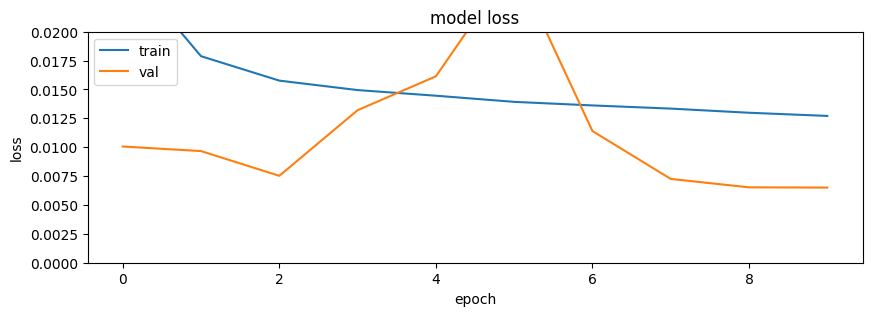

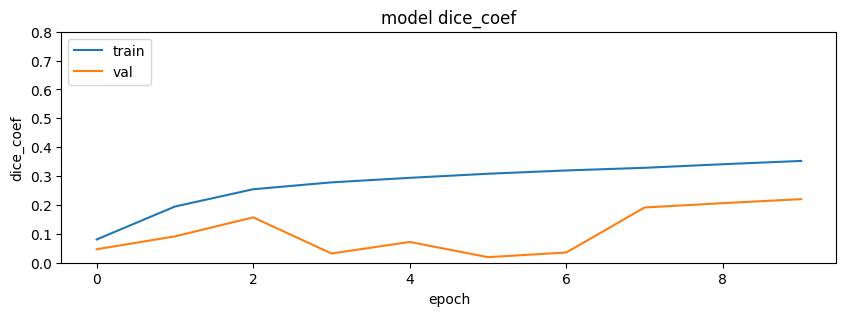

In [43]:
if TRAIN:
    print('History', history.history.keys())

    for var, yrange in [('loss', [0.0, 0.02]),
                        ('dice_coef', [0.0, 0.8])]:
        plt.figure(figsize=(10, 3))
        plt.plot(history.history[var])
        plt.plot(history.history[f'val_{var}'])
        plt.ylim(yrange[0], yrange[1])
        plt.title(f'model {var}')
        plt.xlabel('epoch')
        plt.ylabel(var)
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

# Evaluate

In [44]:
def apply_threshold(pred, threshold):
    return (pred > threshold).astype(np.int8)

In [45]:
EVALUATE = True
ALL_BATCHES = True
BATCH_IDX = 0
SAMPLE_IDX = 11

In [46]:
if EVALUATE:    
    # Evaluate the model

    if ALL_BATCHES:
        loss, acc = model.evaluate(partial_set, verbose=2)
    else:
        eval_images, eval_masks = partial_set[BATCH_IDX]
        loss, acc = model.evaluate(eval_images, eval_masks, verbose=2)

    print("Model accuracy: {:5.2f}%".format(100 * acc))

8/8 - 34s - loss: 0.0074 - dice_coef: 0.2389 - 34s/epoch - 4s/step
Model accuracy: 23.89%


In [47]:
def eval_dice_coef(sample_set, pred_set, batch_size, threshold):
    dice_coef_per_batch = np.full(len(sample_set), np.nan)
    for idx in range(len(sample_set)):
        x, y = sample_set[idx]
        pred = pred_set[idx*batch_size:(idx + 1)*batch_size]
        _coef = dice_coef(y, pred, threshold=threshold)
        dice_coef_per_batch[idx] = _coef
    return dice_coef_per_batch

if EVALUATE:
    
    predictions = model.predict(partial_set)
    
    _coefs = eval_dice_coef(
        partial_set, predictions, batch_size=partial_set.batch_size, threshold=None)
    print(f'w/o threshold: {_coefs.mean():.2%}')
    
    if Config.threshold == 'auto':
        best_coef = 0.
        for threshold in np.arange(0.1, 0.8, 0.1):
            _coefs = eval_dice_coef(
                partial_set, predictions, batch_size=partial_set.batch_size, threshold=threshold)
            mean_coef = _coefs.mean()
            if mean_coef > best_coef:
                best_coef = mean_coef
                best_thresh = threshold
            print(f'{threshold:.02} threshold: {mean_coef:.2%}')
        print(f'best_threshold = {best_thresh:.02}')
        Config.threshold = best_thresh
        print('Config.threshold updated')
    else:
        threshold = Config.threshold
        _coefs = eval_dice_coef(
            partial_set, predictions, batch_size=partial_set.batch_size, threshold=threshold)
        mean_coef = _coefs.mean()
        print(f'{threshold:.02} threshold: {mean_coef:.2%}')

8/8 [==============================] - 8s 1s/step
w/o threshold: 23.89%
0.1 threshold: 41.58%
0.2 threshold: 38.13%
0.3 threshold: 33.41%
0.4 threshold: 28.73%
0.5 threshold: 22.68%
0.6 threshold: 16.41%
0.7 threshold: 10.39%
best_threshold = 0.1
Config.threshold updated


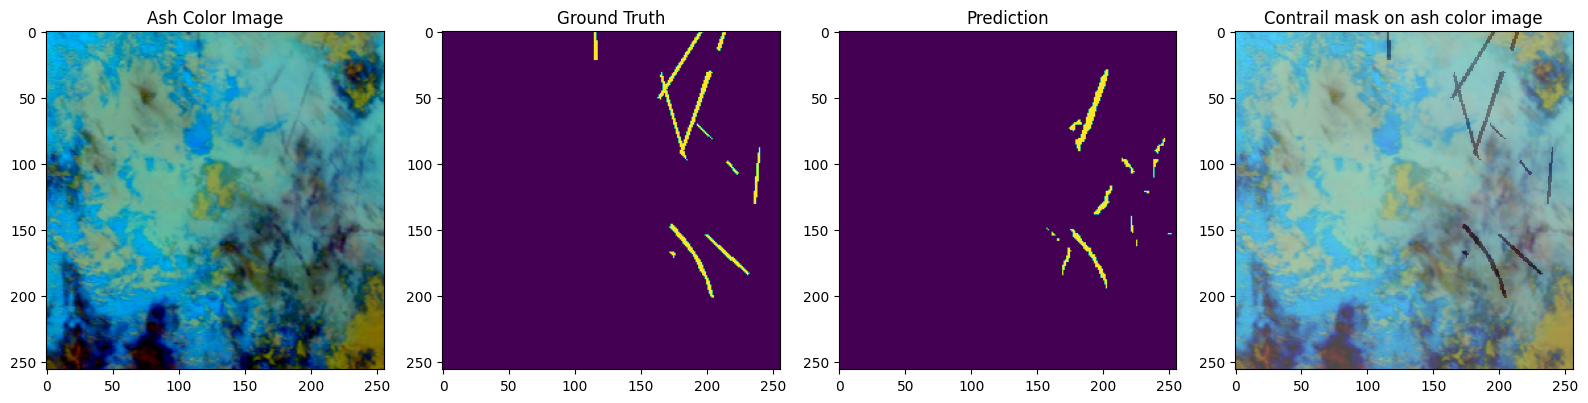

In [48]:
def plot_prediction(img, truth, pred):

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    axs[0].imshow(img)
    axs[0].set_title("Ash Color Image")

    axs[1].imshow(truth)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred)
    axs[2].set_title("Prediction")

    axs[3].imshow(img)
    axs[3].imshow(truth, cmap='Reds', alpha=.3, interpolation='none')
    axs[3].set_title('Contrail mask on ash color image')

    plt.tight_layout() 
    plt.show()

    return

if EVALUATE:
    eval_images, eval_masks = partial_set[BATCH_IDX]
    idx = SAMPLE_IDX
    threshold = Config.threshold
    plot_prediction(
        eval_images[idx], eval_masks[idx], apply_threshold(predictions[idx], threshold))

## Make predictions on test dataset

In [49]:
predictions = model.predict(test_set)

1/1 [==============================] - 0s 103ms/step


In [50]:
len(predictions)

16

## Create a submission

In [51]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


In [52]:
test_recs = os.listdir(os.path.join(DATA_DIR, 'test'))

In [53]:
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='record_id')[0:0]

for test_id, pred in zip(test_ids, predictions):
    
    mask = apply_threshold(pred, Config.threshold)
    
    # notice the we're converting rec to an `int` here:
    submission.loc[int(test_id), 'encoded_pixels'] = list_to_string(rle_encode(mask))
    
submission.to_csv('submission.csv')

In [54]:
def strf_timedelta(timedelta):
    total_seconds = timedelta.total_seconds()
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))

end_time = datetime.datetime.now(timezone('CET'))

print('Terminated', end_time.strftime(PRINT_TIME_FORMAT),
      'in', strf_timedelta(end_time - start_time))

Terminated 2023-07-24 19:17:37 CEST+0200 in 00:51:37


---

THIS IS THE END!